# 2. Predicting stock price with LSTM

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.08.11 </div> 
<div style="text-align: right"> Last update: 2020.08.11</div> 

- 참고자료 : https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

본 자료는 참고자료의 내용을 필사하고 번역한 것이다.  
LSTM으로 GE 주식 데이터를 예측한다.

### 1. 데이터셋 살펴보기

`ge_stock.csv` 데이터셋을 사용한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_rows', 500)

from sklearn.metrics import mean_squared_error

In [2]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/ge_stock.csv'
df = pd.read_csv(url)

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14058 entries, 0 to 14057
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     14058 non-null  object 
 1   Open     14058 non-null  float64
 2   High     14058 non-null  float64
 3   Low      14058 non-null  float64
 4   Close    14058 non-null  float64
 5   Volume   14058 non-null  int64  
 6   OpenInt  14058 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 768.9+ KB


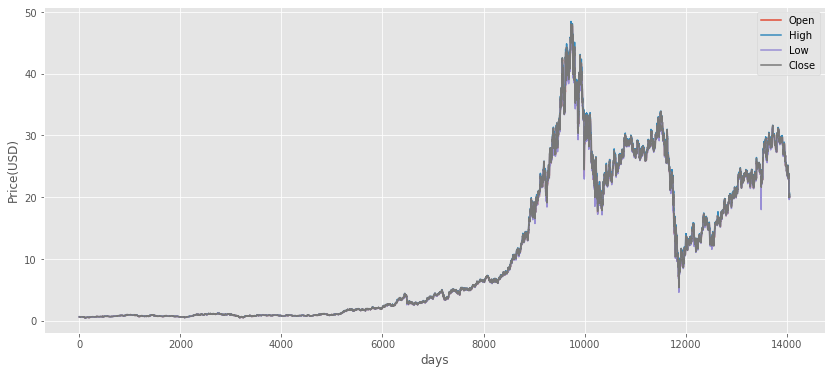

In [5]:
df[['Open', 'High', 'Low', 'Close']].plot(figsize = (14, 6))
plt.xlabel('days')
plt.ylabel('Price(USD)')
plt.show()

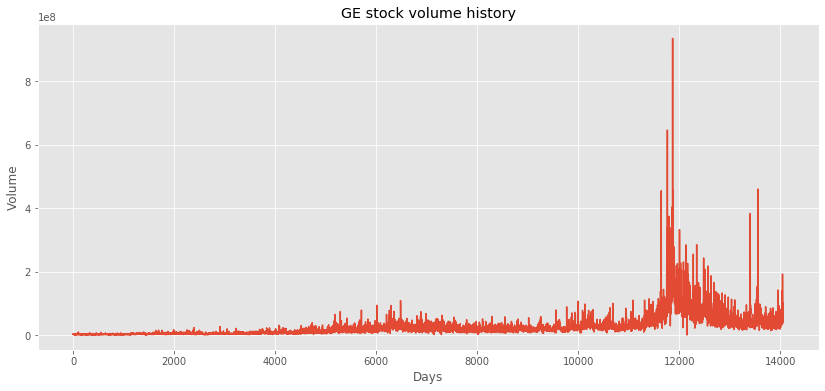

In [6]:
df['Volume'].plot(figsize = (14, 6))
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

- 12000 이전에는 surge가 별로 없다가 12000 부근에서 거래량이 급격하다.  
- 이 당시에 주가는 급락했다.  
- 당시의 뉴스기사를 살펴보면 좋을 듯 하다.

결측치 확인

In [7]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


### 2. 전처리

컬럼선정

In [8]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

학습/ 시험용 데이터 나누기

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train, test = train_test_split(df, test_size = 0.2, shuffle = False)

In [11]:
train.head()

,Open,High,Low,Close,Volume
0,0.6277,0.6362,0.6201,0.6201,2575579
1,0.6201,0.6201,0.6122,0.6201,1764749
2,0.6201,0.6201,0.6037,0.6122,2194010
3,0.6122,0.6122,0.5798,0.5957,3255244
4,0.5957,0.5957,0.5716,0.5957,3696430


In [12]:
test.head()

,Open,High,Low,Close,Volume
11246,27.935,28.049,27.769,28.049,33326250
11247,27.814,28.066,27.776,28.003,25448731
11248,28.099,28.178,27.953,28.058,41464854
11249,27.896,28.146,27.867,28.073,28423137
11250,28.066,28.066,27.858,28.058,23181436


스케일링

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [16]:
train[:5]

array([[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02108267],
       [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
       [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
       [0.00323903, 0.00302758, 0.00272904, 0.00287161, 0.02730914],
       [0.00289013, 0.00268378, 0.0025551 , 0.00287161, 0.03135089]])

In [17]:
test[:5]

array([[0.58098604, 0.57472167, 0.57944514, 0.57965821, 0.30279224],
       [0.57842746, 0.5750759 , 0.57959362, 0.57869176, 0.2306256 ],
       [0.58445385, 0.57740962, 0.583348  , 0.57984729, 0.3773507 ],
       [0.58016137, 0.57674284, 0.58152384, 0.58016244, 0.2578744 ],
       [0.58375606, 0.5750759 , 0.58133294, 0.57984729, 0.20985472]])

In [18]:
print("Are any NaNs present in train/test matrices?",np.isnan(train).any(), np.isnan(test).any())

Are any NaNs present in train/test matrices? False False


LSTM용 데이터셋 만들기 : [ batch_size, time_steps, Features ]

<img src = 'https://miro.medium.com/max/700/1*bY3O4LR2IpgqwwFXHDmTbA.png' width = 400>

In [19]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

In [20]:
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [21]:
from tqdm._tqdm_notebook import tqdm_notebook

In [22]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [23]:
X_train, y_train = build_timeseries(train, 3)

dim_0 11186



length of time-series i/o (11186, 60, 5) (11186,)


- timestep이 60임

In [24]:
X_train[0]

array([[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02108267],
       [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
       [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
       [0.00323903, 0.00302758, 0.00272904, 0.00287161, 0.02730914],
       [0.00289013, 0.00268378, 0.0025551 , 0.00287161, 0.03135089],
       [0.00289013, 0.00285047, 0.00289873, 0.00287161, 0.02293968],
       [0.00289013, 0.00285047, 0.00306629, 0.00287161, 0.01889791],
       [0.00289013, 0.00268378, 0.00289873, 0.00287161, 0.01529311],
       [0.00289013, 0.00285047, 0.00289873, 0.00270563, 0.01594855],
       [0.00289013, 0.00268378, 0.00306629, 0.00287161, 0.02064569],
       [0.00289013, 0.00285047, 0.00306629, 0.00303969, 0.01267147],
       [0.00305929, 0.00285047, 0.00289873, 0.00270563, 0.02086418],
       [0.00272308, 0.00268378, 0.00289873, 0.00287161, 0.01365459],
       [0.00289013, 0.00285047, 0.00306629, 0.00303969, 0.01201608],
       [0.00305929, 0.00302758, 0.

In [25]:
y_train[0]

0.00405445891735148

In [26]:
train[60]

array([0.00391567, 0.00385688, 0.00409504, 0.00405446, 0.01201608])

- train의 4번째 값(close) 부터 반영된 것 확인

데이터를 다시 배치로 나누어지도록 처리  
- 데이터가 배치단위(여기서는 20)로 나누어 떨어지도록 처리한다.

In [27]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [28]:
X_train = trim_dataset(X_train, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)

In [29]:
X_train.shape

(11180, 60, 5)

In [30]:
y_train.shape

(11180,)

시험용/ 검증용 데이터셋 만들기

In [31]:
X_temp, y_temp = build_timeseries(test, 3)
X_val, X_test = np.split(trim_dataset(X_temp, BATCH_SIZE),2)
y_val, y_test = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 2752



length of time-series i/o (2752, 60, 5) (2752,)


In [32]:
X_val.shape

(1370, 60, 5)

In [33]:
X_test.shape

(1370, 60, 5)

In [34]:
y_val.shape

(1370,)

In [35]:
y_test.shape

(1370,)

### 3. 모델 만들기

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop

In [37]:
import time

In [38]:
model = Sequential()
model.add(LSTM(units=100, batch_input_shape = (BATCH_SIZE, TIME_STEPS,
                                              X_train.shape[2]),
              dropout = 0.0, recurrent_dropout=0.0, stateful = True, 
              return_sequences=True, kernel_initializer='random_uniform'))
model.add(Dropout(0.4))
model.add(LSTM(units=60, dropout=0.0))
model.add(Dropout(0.4))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [39]:
optimizer = RMSprop(lr=params["lr"])
model.compile(loss = 'mse', optimizer= optimizer)

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
mcp = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

In [42]:
csv_logger = CSVLogger('training_log_' + time.ctime().replace(" ","_") + '.log', 
                       append=True)

In [43]:
history = model.fit(X_train, y_train, epochs=params["epochs"], verbose=2, 
                    batch_size=BATCH_SIZE, shuffle=False, 
          validation_data=(trim_dataset(X_val, BATCH_SIZE),trim_dataset(y_val, BATCH_SIZE)), 
                callbacks=[es, mcp])

Epoch 1/300

Epoch 00001: val_loss improved from inf to 0.03306, saving model to best_model.h5
559/559 - 9s - loss: 0.0178 - val_loss: 0.0331
Epoch 2/300

Epoch 00002: val_loss improved from 0.03306 to 0.00454, saving model to best_model.h5
559/559 - 3s - loss: 0.0063 - val_loss: 0.0045
Epoch 3/300

Epoch 00003: val_loss improved from 0.00454 to 0.00309, saving model to best_model.h5
559/559 - 3s - loss: 0.0022 - val_loss: 0.0031
Epoch 4/300

Epoch 00004: val_loss did not improve from 0.00309
559/559 - 3s - loss: 0.0018 - val_loss: 0.0032
Epoch 5/300

Epoch 00005: val_loss improved from 0.00309 to 0.00285, saving model to best_model.h5
559/559 - 3s - loss: 0.0017 - val_loss: 0.0028
Epoch 6/300

Epoch 00006: val_loss improved from 0.00285 to 0.00208, saving model to best_model.h5
559/559 - 3s - loss: 0.0015 - val_loss: 0.0021
Epoch 7/300

Epoch 00007: val_loss improved from 0.00208 to 0.00175, saving model to best_model.h5
559/559 - 3s - loss: 0.0013 - val_loss: 0.0017
Epoch 8/300

Epoc

Epoch 65/300

Epoch 00065: val_loss did not improve from 0.00099
559/559 - 3s - loss: 4.1283e-04 - val_loss: 0.0011
Epoch 66/300

Epoch 00066: val_loss did not improve from 0.00099
559/559 - 3s - loss: 4.3042e-04 - val_loss: 0.0013
Epoch 67/300

Epoch 00067: val_loss did not improve from 0.00099
559/559 - 3s - loss: 4.1510e-04 - val_loss: 0.0011
Epoch 68/300

Epoch 00068: val_loss did not improve from 0.00099
559/559 - 3s - loss: 4.4477e-04 - val_loss: 0.0012
Epoch 69/300

Epoch 00069: val_loss did not improve from 0.00099
559/559 - 3s - loss: 4.2925e-04 - val_loss: 0.0011
Epoch 70/300

Epoch 00070: val_loss did not improve from 0.00099
559/559 - 3s - loss: 4.2599e-04 - val_loss: 0.0013
Epoch 71/300

Epoch 00071: val_loss did not improve from 0.00099
559/559 - 3s - loss: 4.1735e-04 - val_loss: 0.0013
Epoch 72/300

Epoch 00072: val_loss did not improve from 0.00099
559/559 - 3s - loss: 4.1031e-04 - val_loss: 0.0011
Epoch 73/300

Epoch 00073: val_loss did not improve from 0.00099
559/559

### 5. 모델 저장

In [44]:
import pickle

In [45]:
# print("saving model...")
# pickle.dump(model, open("lstm_model", "wb"))

### 6. 평가

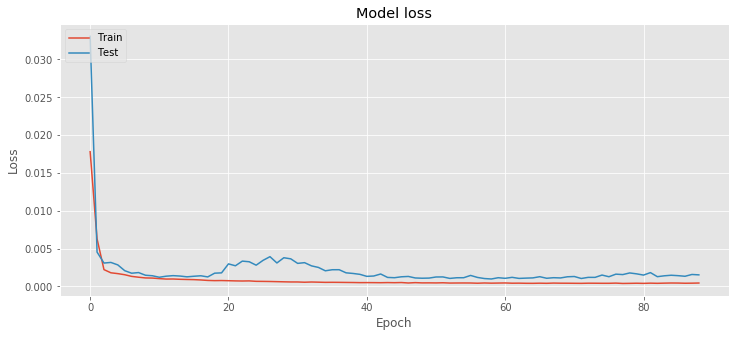

In [46]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [47]:
from tensorflow.keras.models import load_model

In [48]:
saved_model = load_model('best_model.h5') # , "lstm_best_7-3-19_12AM",
print(saved_model)

In [49]:
y_pred = saved_model.predict(trim_dataset(X_test, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test = trim_dataset(y_test, BATCH_SIZE)
error = mean_squared_error(y_test, y_pred)
print("Error is", error, y_pred.shape, y_test.shape)
print(y_pred[0:15])
print(y_test[0:15])
y_pred_org = (y_pred * scaler.data_range_[3]) + scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test *scaler.data_range_[3]) + scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.0011732602543242866 (1360,) (1360,)
[0.39366    0.3917437  0.38956487 0.3886603  0.38822374 0.38722318
 0.38737303 0.38864836 0.39013112 0.39115724 0.39145312 0.39035773
 0.38776705 0.38561952 0.38199177]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[19.196049 19.104837 19.001133 18.958078 18.937298 18.889675 18.896807
 18.95751  19.028084 19.076925 19.091007 19.03887  18.915562 18.813345
 18.640676]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


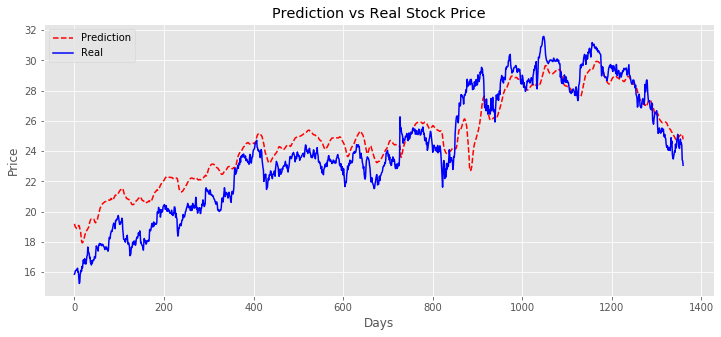

In [50]:
plt.figure(figsize = (12, 5))
plt.plot(y_pred_org, 'r--')
plt.plot(y_test_t_org, 'b')
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')